<a href="https://colab.research.google.com/github/11TRNP/Autoimmune-Nonautoimmune-Classification/blob/main/ResNet50_86%25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import Model
from keras.layers import Rescaling
from keras.layers import Resizing

# System libraries
from pathlib import Path
import os.path
import random

# Visualization Libraries
import matplotlib.cm as cm
import cv2
import seaborn as sns

sns.set_style('darkgrid')

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [2]:
BATCH_SIZE = 32
TARGET_SIZE = (224, 224)

In [4]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

--2024-12-16 03:48:05--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-12-16 03:48:05 (106 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [5]:
from google.colab import drive
import os

drive.mount('/content/drive/')

Mounted at /content/drive/


In [6]:
base_dir = '/content/drive/My Drive/DATASET/source'
output_dir = '/content/drive/My Drive/DATASET/output'
train_dir = '/content/drive/My Drive/DATASET/output/train'
val_dir = '/content/drive/My Drive/DATASET/output/val'
test_dir = '/content/drive/My Drive/DATASET/output/test'
augmented_dir = '/content/drive/My Drive/DATASET/output/augmented/'

print(os.listdir(augmented_dir))
print(" ")
print(os.listdir(output_dir))

['Autoimun_Dermatomyositis', 'Autoimun_Vitiligo', 'Autoimun_Psoriasis', 'Autoimun_Lichen_Planus', 'Nonautoimun_Tinea', 'Nonautoimun_Eczema', 'Nonautoimun_Herpes', 'Nonautoimun_Keratosis_Seborrheic', 'labels_augmented.csv']
 
['test', 'val', 'manipulation', 'train', 'augmented', 'mask']


In [7]:
image_dir = Path(augmented_dir)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png'))  + list(image_dir.glob(r'**/*.jpeg')) + list(image_dir.glob(r'**/*.gif'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

<ipython-input-8-371b102a4acd>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='dark:salmon_r')


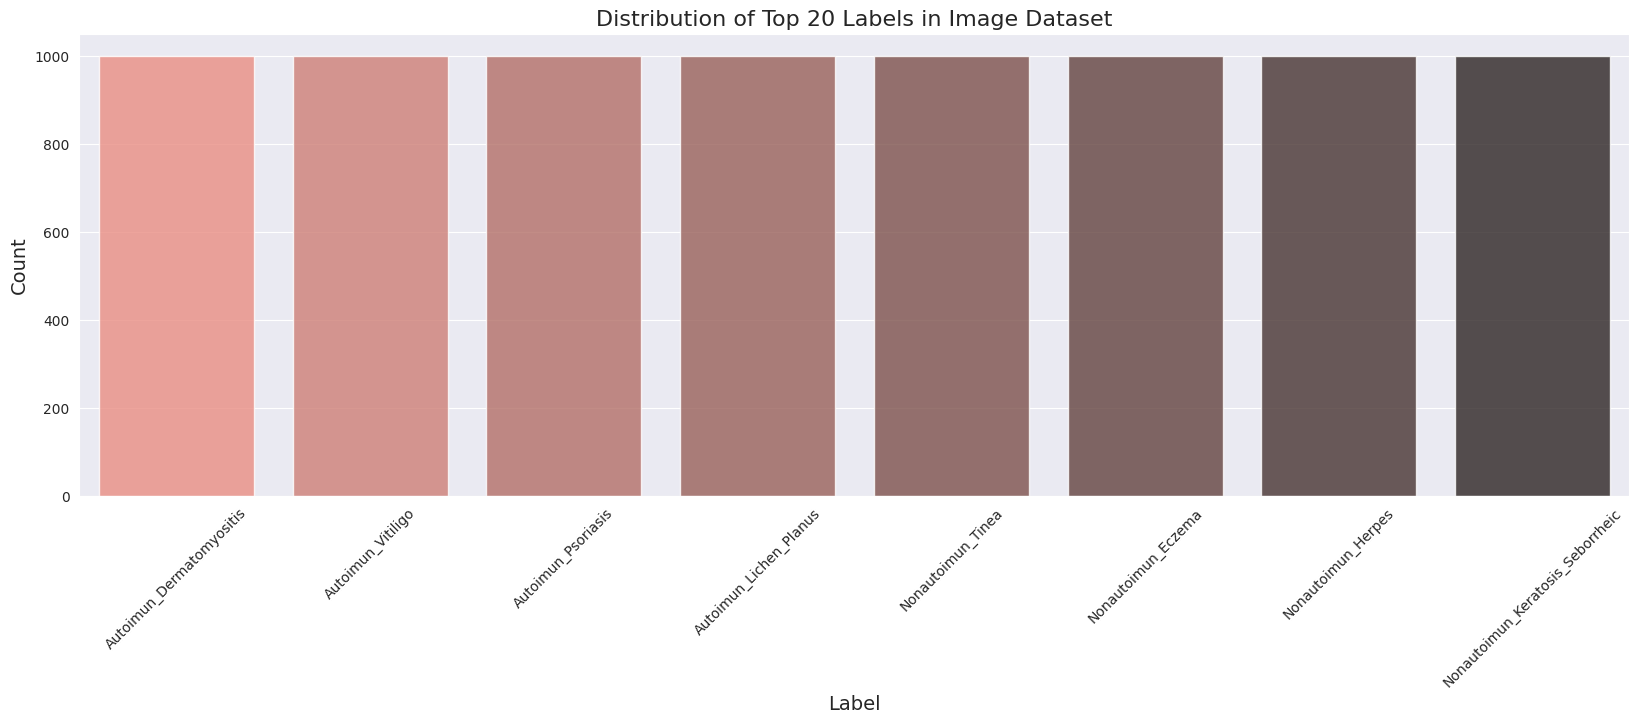

In [8]:
# Get the top 20 labels
label_counts = image_df['Label'].value_counts()[:20]

plt.figure(figsize=(20, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='dark:salmon_r')
plt.title('Distribution of Top 20 Labels in Image Dataset', fontsize=16)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45)
plt.show()

In [9]:
image_df

Filepath  \
0     /content/drive/My Drive/DATASET/output/augment...   
1     /content/drive/My Drive/DATASET/output/augment...   
2     /content/drive/My Drive/DATASET/output/augment...   
3     /content/drive/My Drive/DATASET/output/augment...   
4     /content/drive/My Drive/DATASET/output/augment...   
...                                                 ...   
7995  /content/drive/My Drive/DATASET/output/augment...   
7996  /content/drive/My Drive/DATASET/output/augment...   
7997  /content/drive/My Drive/DATASET/output/augment...   
7998  /content/drive/My Drive/DATASET/output/augment...   
7999  /content/drive/My Drive/DATASET/output/augment...   

                                 Label  
0             Autoimun_Dermatomyositis  
1             Autoimun_Dermatomyositis  
2             Autoimun_Dermatomyositis  
3             Autoimun_Dermatomyositis  
4             Autoimun_Dermatomyositis  
...                                ...  
7995  Nonautoimun_Keratosis_Seborrheic  
7996  Nonautoimun_Keratosis_Seborrheic  
7997  Nonautoimun_Keratosis_Seborrheic  
7998  Nonautoimun_Keratosis_Seborrheic  
7999  Nonautoimun_Keratosis_Seborrheic  

[8000 rows x 2 columns]

In [10]:
import pandas as pd
import os
from google.colab import sheets

# Daftar nama penyakit
diseases = ['Autoimun_Dermatomyositis', 'Autoimun_Vitiligo', 'Autoimun_Psoriasis', 'Autoimun_Lichen_Planus',
            'Nonautoimun_Tinea', 'Nonautoimun_Eczema', 'Nonautoimun_Herpes', 'Nonautoimun_Keratosis_Seborrheic']

# Assuming 'Filepath' column contains the image paths
# Ambil path base directory dari DataFrame image_df
base_dir = os.path.dirname(image_df['Filepath'][0])  # Changed 'image' to 'Filepath'

# Buat list kosong untuk menyimpan data
data = []

# Iterasi melalui setiap baris di image_df
for index, row in image_df.iterrows():
    # Use 'Filepath' column instead of 'image'
    image_path = row['Filepath']

    # Ekstrak nama penyakit dari path gambar
    disease_name = os.path.basename(os.path.dirname(image_path))

    # Buat dictionary untuk setiap baris data
    row_data = {'image': image_path} # You might want to change this key to 'Filepath' for consistency

    # Inisialisasi semua label penyakit menjadi 0
    for d in diseases:
        row_data[d.lower()] = 0

    # Set label penyakit yang sesuai menjadi 1
    if disease_name in diseases:
        row_data[disease_name.lower()] = 1

    # Tambahkan baris data ke list
    data.append(row_data)

# Buat DataFrame dari list data
label_df = pd.DataFrame(data)

print(label_df)

                                                  image  \
0     /content/drive/My Drive/DATASET/output/augment...   
1     /content/drive/My Drive/DATASET/output/augment...   
2     /content/drive/My Drive/DATASET/output/augment...   
3     /content/drive/My Drive/DATASET/output/augment...   
4     /content/drive/My Drive/DATASET/output/augment...   
...                                                 ...   
7995  /content/drive/My Drive/DATASET/output/augment...   
7996  /content/drive/My Drive/DATASET/output/augment...   
7997  /content/drive/My Drive/DATASET/output/augment...   
7998  /content/drive/My Drive/DATASET/output/augment...   
7999  /content/drive/My Drive/DATASET/output/augment...   

      autoimun_dermatomyositis  autoimun_vitiligo  autoimun_psoriasis  \
0                            1                  0                   0   
1                            1                  0                   0   
2                            1                  0                   0   

In [11]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=label_df)

https://docs.google.com/spreadsheets/d/1KrvCBAS3bgxdg_vhqMKnmAAkmYW7c7kOm2uOVbRhFhU#gid=0


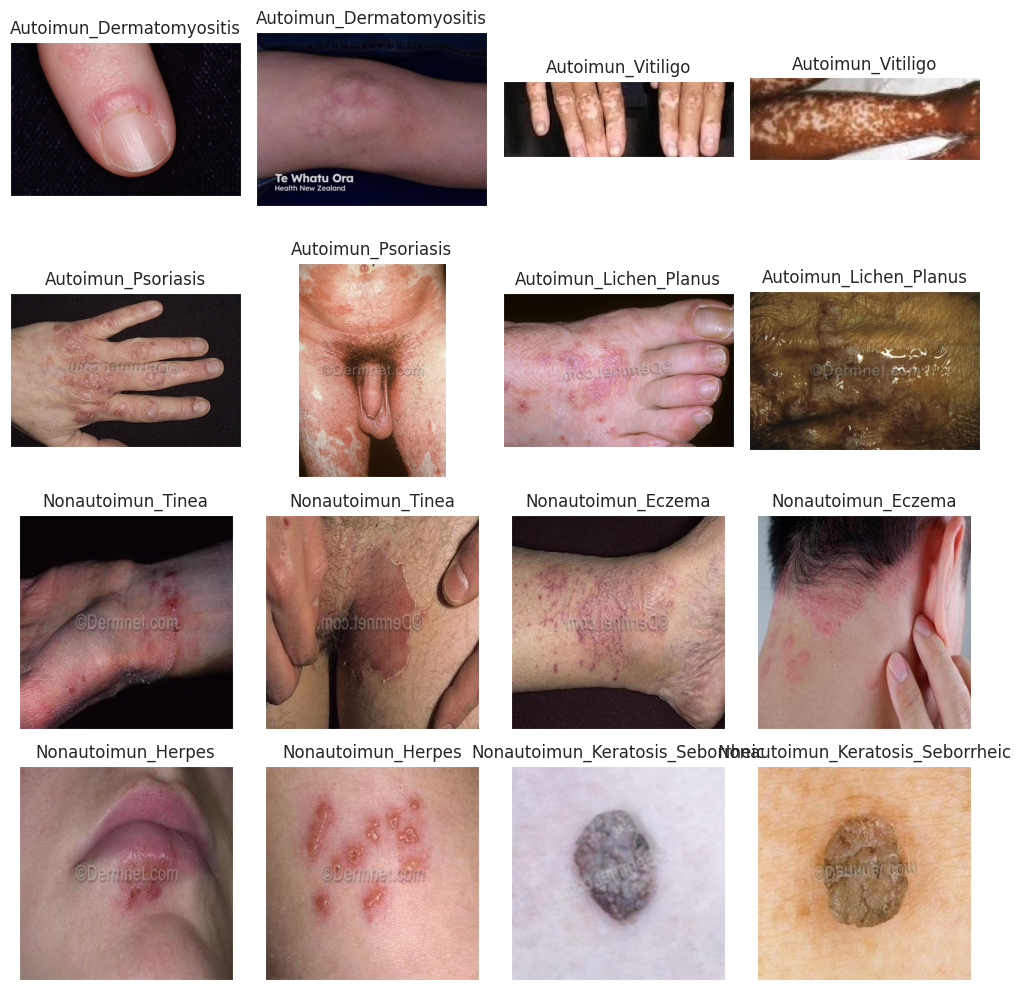

In [12]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

augmented_dir = '/content/drive/My Drive/DATASET/output/augmented' # Replace with your base directory
diseases = ['Autoimun_Dermatomyositis', 'Autoimun_Vitiligo', 'Autoimun_Psoriasis', 'Autoimun_Lichen_Planus',
            'Nonautoimun_Tinea', 'Nonautoimun_Eczema', 'Nonautoimun_Herpes', 'Nonautoimun_Keratosis_Seborrheic']

num_images_per_disease = 2

# Collect image paths for each disease
image_paths = []
for disease in diseases:
    disease_dir = os.path.join(augmented_dir, disease)
    image_files = [f for f in os.listdir(disease_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif'))]
    image_paths.extend([os.path.join(disease_dir, f) for f in random.sample(image_files, num_images_per_disease)])

# Display the images
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10), subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    img = mpimg.imread(image_paths[i])
    ax.imshow(img)
    ax.set_title(os.path.basename(os.path.dirname(image_paths[i])))  # Extract disease name from path
plt.tight_layout()
plt.show()

In [13]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

In [14]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    validation_split=0.2
)

val_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input
)

In [15]:
# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 5120 validated image filenames belonging to 8 classes.
Found 1280 validated image filenames belonging to 8 classes.
Found 1600 validated image filenames belonging to 8 classes.


In [16]:
# Resize Layer
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(224, 224), # Use layers.Resizing directly
  layers.Rescaling(1./255),  # Use layers.Rescaling directly
])

In [17]:
# Load the pretained model
base_model = tf.keras.applications.ResNet50(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

base_model.trainable = False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [18]:
# Create checkpoint callback
checkpoint_path = "autoimun_nonautoimun_classification_model_checkpoint.weights.h5"  # Added .weights.h5 extension
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [19]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

In [20]:
import tensorflow as tf
from tensorflow.keras.layers import Resizing, Rescaling
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model

inputs = base_model.input
x = base_model.output
x = resize_and_rescale(inputs)
x = Dense(1024, activation='relu')(base_model.output)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
x = Flatten()(x)
outputs = tf.keras.layers.Dense(8, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)


model.compile(
    optimizer=tf.keras.optimizers.Adamax(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 26,214,792 (100.00 MB)

 Trainable params: 2,627,080 (10.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [21]:
import os
os.environ["PATH"] += os.pathsep + '/usr/local/bin/'

from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model

print("\nTrainable Variables for Specific Layers:")

# Input layer
print("Input Layer:", model.input.name)

# Dense layers
for layer in model.layers:
    if isinstance(layer, Dense):
        print(f"Dense Layer ({layer.name}):")
        for weight in layer.trainable_variables:
            print(f"  - {weight.name}")

# Dropout layers
for layer in model.layers:
    if isinstance(layer, Dropout):
        print(f"Dropout Layer ({layer.name}):")
        # Dropout layers usually don't have trainable variables

# Flatten layer (if present)
for layer in model.layers:
    if isinstance(layer, Flatten):
        print(f"Flatten Layer ({layer.name}):")
        # Flatten layers don't have trainable variables

# Output layer
print(f"Output Layer ({model.layers[-1].name}):")  # Assuming the last layer is the output layer
for weight in model.layers[-1].trainable_variables:
    print(f"  - {weight.name}")

print(f"\nNumber of trainable variables: {len(model.trainable_variables)}")


Trainable Variables for Specific Layers:
Input Layer: keras_tensor
Dense Layer (dense):
  - kernel
  - bias
Dense Layer (dense_1):
  - kernel
  - bias
Dense Layer (dense_2):
  - kernel
  - bias
Dropout Layer (dropout):
Dropout Layer (dropout_1):
Flatten Layer (flatten):
Output Layer (dense_2):
  - kernel
  - bias

Number of trainable variables: 6


In [22]:
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LambdaCallback
import datetime

# Pelatihan model
history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=30,
    callbacks=[
        early_stopping,  # Early stopping based on val_loss
        create_tensorboard_callback("training_logs", "autoimun_classification"),
        checkpoint_callback])

Saving TensorBoard log files to: training_logs/autoimun_classification/20241216-035120
Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


160/160 ━━━━━━━━━━━━━━━━━━━━ 2775s 17s/step - accuracy: 0.3689 - loss: 3.6204 - val_accuracy: 0.6727 - val_loss: 1.0600
Epoch 2/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 611us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/30


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_accuracy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


160/160 ━━━━━━━━━━━━━━━━━━━━ 73s 356ms/step - accuracy: 0.5925 - loss: 1.5060 - val_accuracy: 0.7195 - val_loss: 0.8092
Epoch 4/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 164us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 82s 350ms/step - accuracy: 0.6799 - loss: 1.0074 - val_accuracy: 0.7633 - val_loss: 0.6863
Epoch 6/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 123us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 59s 357ms/step - accuracy: 0.7273 - loss: 0.7879 - val_accuracy: 0.7820 - val_loss: 0.6162
Epoch 8/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 236us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 81s 355ms/step - accuracy: 0.7689 - loss: 0.6696 - val_accuracy: 0.7937 - val_loss: 0.5586
Epoch 10/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 204us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 11/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 59s 357ms/step - accuracy: 0.8043 - loss: 0.5586 - val_accura

In [23]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.34827
Test Accuracy: 86.94%


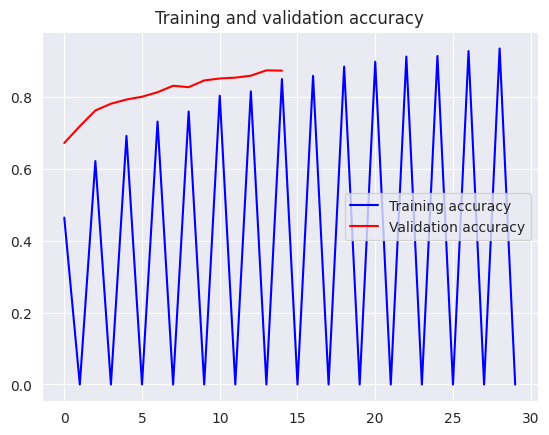

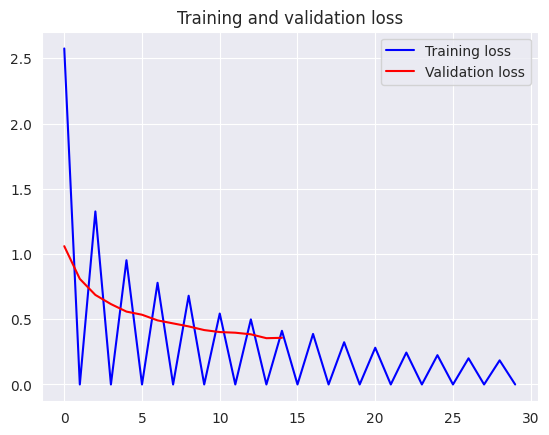

In [24]:
import matplotlib.pyplot as plt

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# Get the number of epochs for training and validation data
epochs_training = range(len(accuracy))
epochs_validation = range(len(val_accuracy))

# Plot training and validation accuracy
plt.plot(epochs_training, accuracy, 'b', label='Training accuracy')
plt.plot(epochs_validation, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()  # Create a new figure for the loss plot

# Plot training and validation loss
plt.plot(epochs_training, loss, 'b', label='Training loss')
plt.plot(epochs_validation, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [25]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 10 predictions: {pred[:10]}')

50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 279ms/step
The first 10 predictions: ['Autoimun_Psoriasis', 'Autoimun_Psoriasis', 'Autoimun_Vitiligo', 'Autoimun_Lichen_Planus', 'Nonautoimun_Tinea', 'Autoimun_Psoriasis', 'Autoimun_Vitiligo', 'Autoimun_Vitiligo', 'Nonautoimun_Tinea', 'Autoimun_Dermatomyositis']


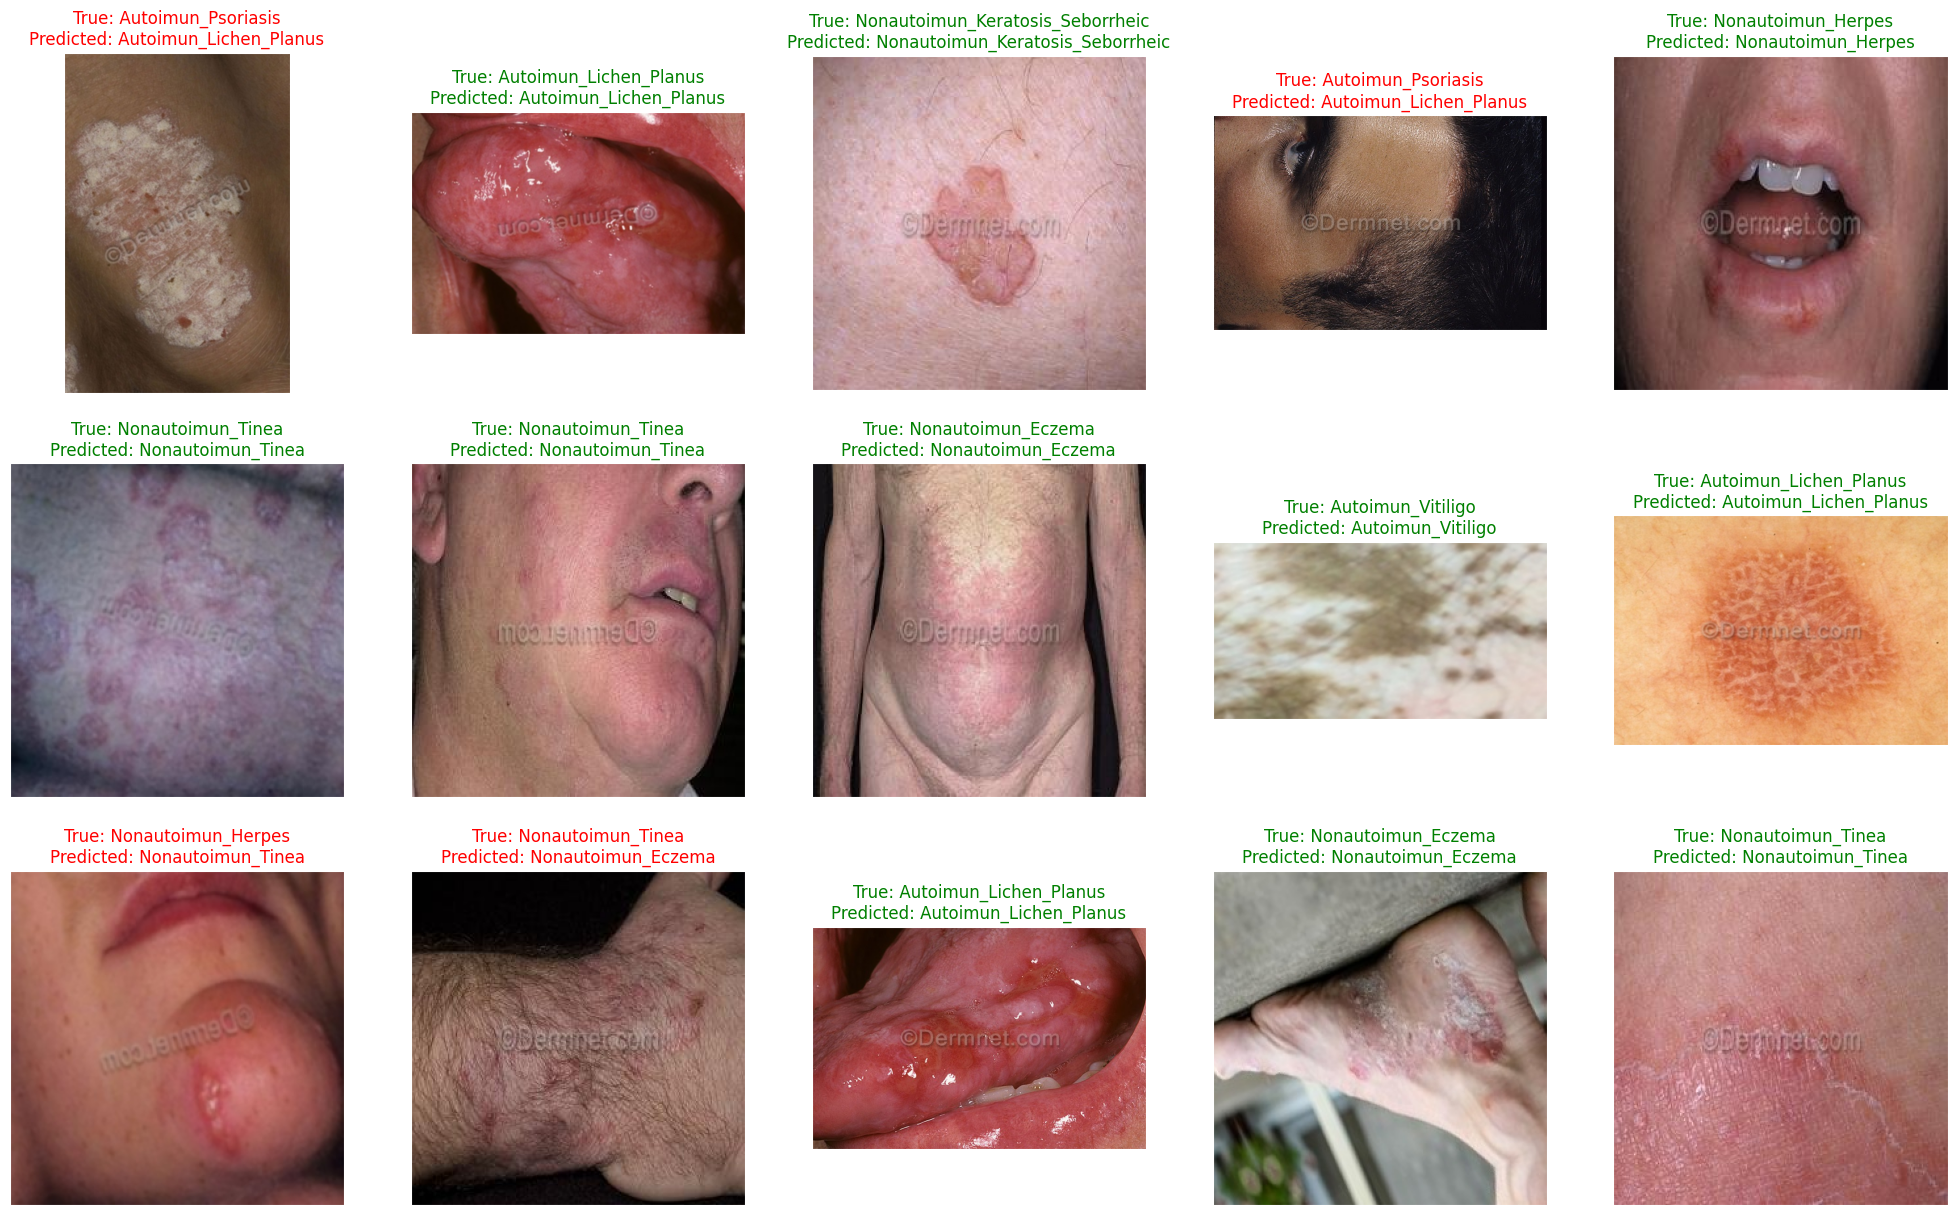

<Figure size 640x480 with 0 Axes>

In [26]:
 # Display 25 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

In [27]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

                                  precision    recall  f1-score   support

        Autoimun_Dermatomyositis       0.94      0.99      0.97       203
          Autoimun_Lichen_Planus       0.85      0.87      0.86       183
              Autoimun_Psoriasis       0.90      0.85      0.87       196
               Autoimun_Vitiligo       1.00      1.00      1.00       222
              Nonautoimun_Eczema       0.80      0.65      0.72       197
              Nonautoimun_Herpes       0.83      0.85      0.84       207
Nonautoimun_Keratosis_Seborrheic       0.92      0.96      0.94       192
               Nonautoimun_Tinea       0.70      0.78      0.74       200

                        accuracy                           0.87      1600
                       macro avg       0.87      0.87      0.87      1600
                    weighted avg       0.87      0.87      0.87      1600



In [28]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

precision    recall  f1-score      support
Autoimun_Dermatomyositis           0.943662  0.990148  0.966346   203.000000
Autoimun_Lichen_Planus             0.850267  0.868852  0.859459   183.000000
Autoimun_Psoriasis                 0.902174  0.846939  0.873684   196.000000
Autoimun_Vitiligo                  1.000000  0.995495  0.997743   222.000000
Nonautoimun_Eczema                 0.801242  0.654822  0.720670   197.000000
Nonautoimun_Herpes                 0.833333  0.845411  0.839329   207.000000
Nonautoimun_Keratosis_Seborrheic   0.915423  0.958333  0.936387   192.000000
Nonautoimun_Tinea                  0.699552  0.780000  0.737589   200.000000
accuracy                           0.869375  0.869375  0.869375     0.869375
macro avg                          0.868207  0.867500  0.866401  1600.000000
weighted avg                       0.870003  0.869375  0.868255  1600.000000

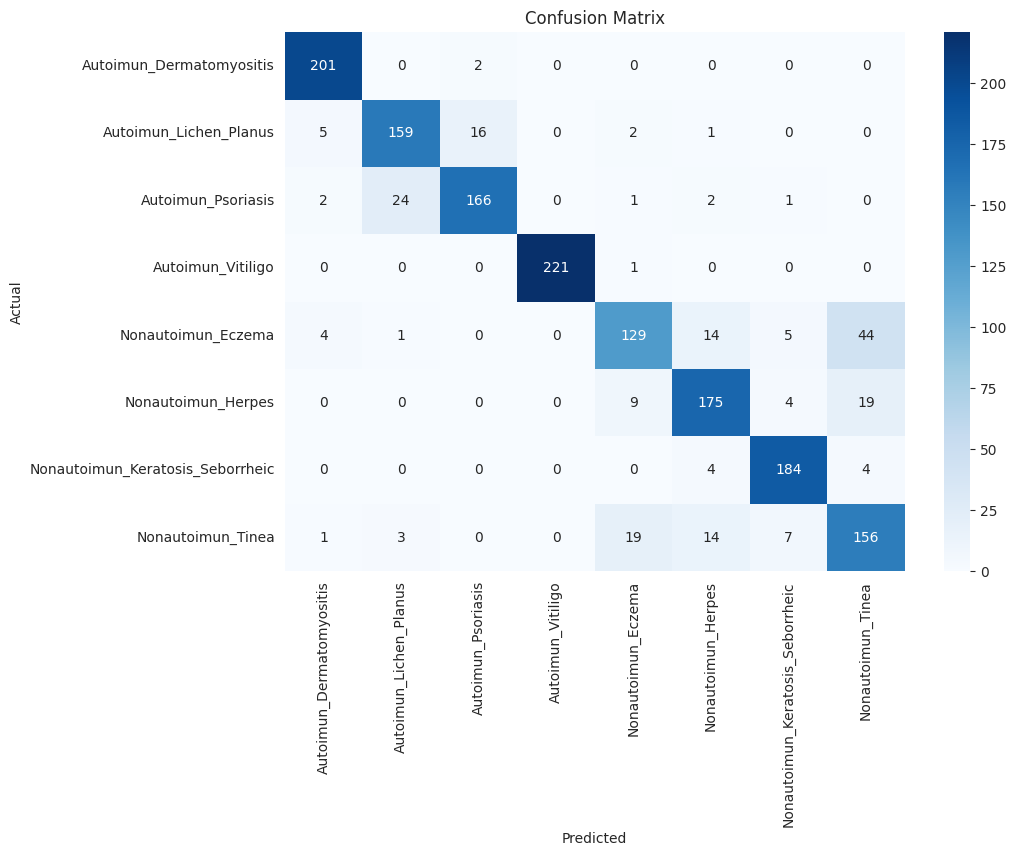

In [29]:
# Import the necessary function from scikit-learn
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


def make_confusion_matrix(y_true, y_pred, labels):
    """
    Generates and displays a confusion matrix.

    Args:
        y_true: The true labels.
        y_pred: The predicted labels.
        labels: A list of label names.
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()


# Now you can use make_confusion_matrix in your code
# Use the complete y_test list instead of slicing it to match the length of pred
make_confusion_matrix(y_test, pred, list(labels.values()))

In [30]:
def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size "size"
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

# Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

        # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [33]:
def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size "size"
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
#     display(Image(cam_path))

    return cam_path


preprocess_input = tf.keras.applications.resnet50.preprocess_input
decode_predictions = tf.keras.applications.resnet50.decode_predictions

last_conv_layer_name = "conv5_block3_3_conv"
img_size = (224,224)

# Remove last layer's softmax
model.layers[-1].activation = None

<ipython-input-33-676dee0b290a>:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


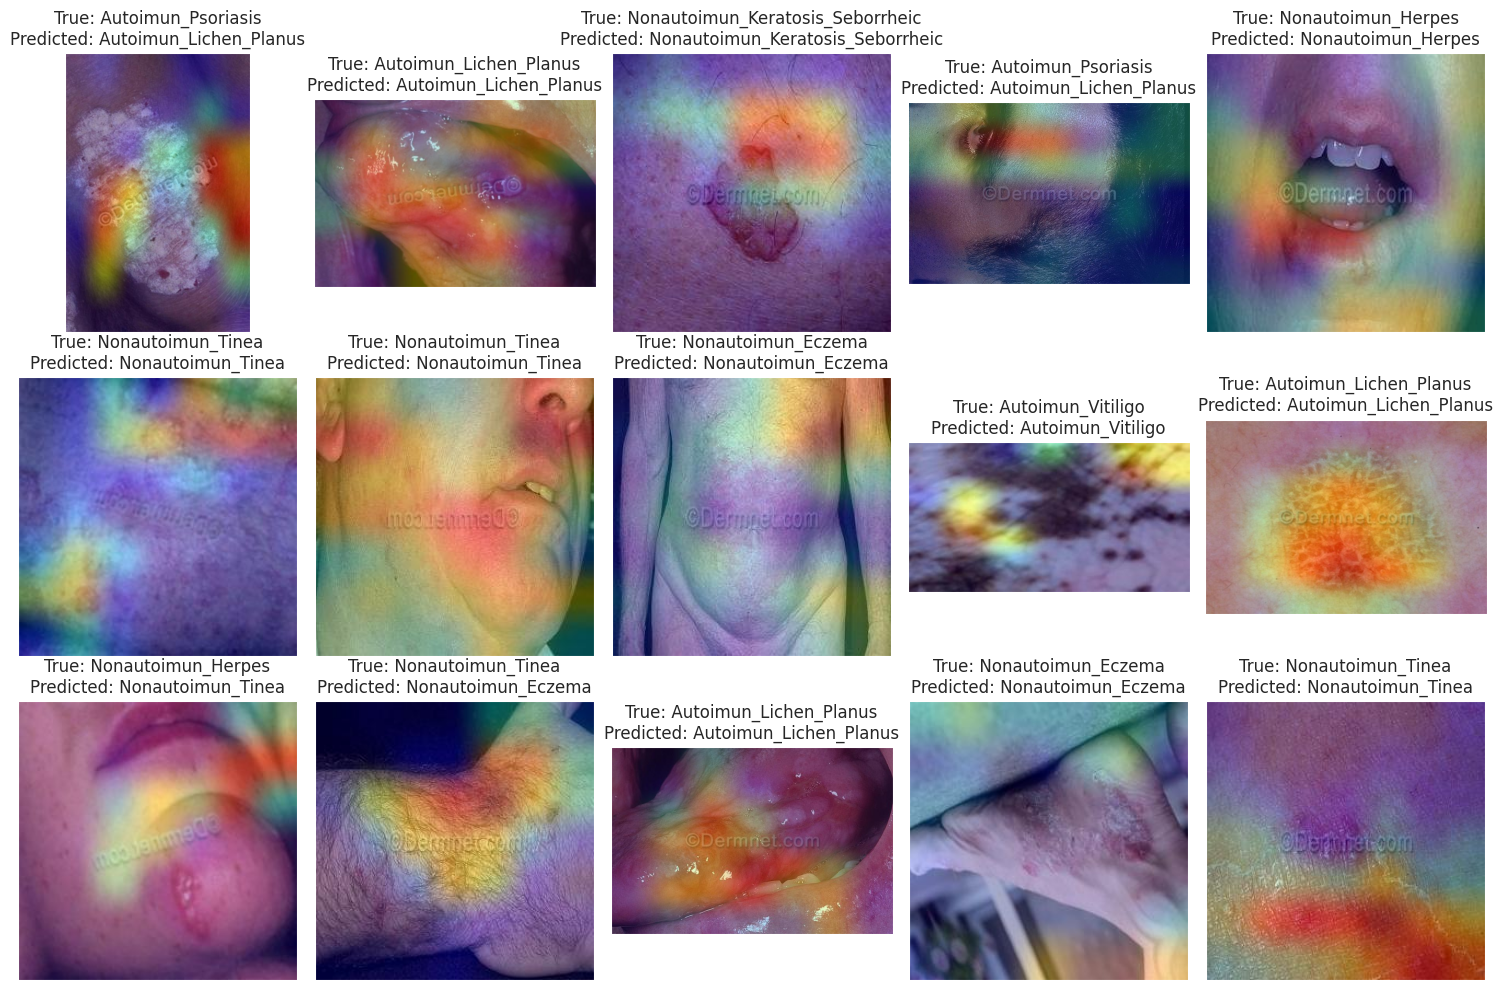

In [34]:
# Display the part of the pictures used by the neural network to classify the pictures
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img_path = test_df.Filepath.iloc[random_index[i]]
    img_array = preprocess_input(get_img_array(img_path, size=img_size))
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    cam_path = save_and_display_gradcam(img_path, heatmap)
    ax.imshow(plt.imread(cam_path))
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}")
plt.tight_layout()
plt.show()